In [4]:
#  Ebnable HTML/CSS 
from IPython.core.display import HTML
HTML("<link href='https://fonts.googleapis.com/css?family=Passion+One' rel='stylesheet' type='text/css'><style>div.attn { font-family: 'Helvetica Neue'; font-size: 30px; line-height: 40px; color: #FFFFFF; text-align: center; margin: 30px 0; border-width: 10px 0; border-style: solid; border-color: #5AAAAA; padding: 30px 0; background-color: #DDDDFF; }hr { border: 0; background-color: #ffffff; border-top: 1px solid black; }hr.major { border-top: 10px solid #5AAA5A; }hr.minor { border: none; background-color: #ffffff; border-top: 5px dotted #CC3333; }div.bubble { width: 65%; padding: 20px; background: #DDDDDD; border-radius: 15px; margin: 0 auto; font-style: italic; color: #f00; }em { color: #AAA; }div.c1{visibility:hidden;margin:0;height:0;}div.note{color:red;}table{margin-left: 0 !important;}</style>")

## Business Understanding

We aim to apply clustering to our crime dataset.  Specifically, we will use crime condition information to identify different patterns in terms of when crimes take place and what the weather conditions are. From these patterns, we will then generalize and explain the meaning behind the clusters we identify.  

### Measuring Effectiveness

We will use the Silhouette Coefficient (score) to determine cluster effectiveness.  The Silhouette score uses euclidean distance to determine if clusters are dense and well separated.  The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering.  Scores closer to 1 are better.


## Data Understanding

The following features are used in this clustering analysis:

|Feature | Description |
|:-------|:------------|
|Daytime | This specifies the general time of day a crime occurred.  i.e. Early Morning, Morning, Day, Evening, Late Evening, Night |
|Day_Name | The weekday name in which a crime occurred |
|Month | The month in which a crime occurred |
|Season | The season in which a crime occurred.  i.e. Winter, Spring, Summer, Fall |
|is_Holiday | Indicates if there was a holiday on the day in which a crime occurred (Boolean 1 = Holiday) |
|is_Event | Indicates if there was an event held in the city on the day a crime occurred (Boolean 1 = Event) |
|PRCP | The amount of precipitation in inches on the day a crime occurred |
|SNOW | The amount of snow in inches on the day a crime occurred |
|TMIN | The minimum temperature in Fahrenheit on the day a crime occurred |
|TMAX | The maximum temperature in Fahrenheit on the day a crime occurred |


With the fields above, we will be able to identify how the records in our dataset cluster and determine the mode of the string features and the average of the continuous features to arrive at a general description.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Pull in the Dataset

In [6]:
#load csv
file_path = "C:\\Users\\BGaither\\OneDrive - McAfee\\Other\\school\\SMU\\Courses\\Fall 2020\\Machine Learning I\\Lab1\\Data_NYPD\\Modified_Data_Sets\\NYPD_Rollup_All_Crimes_Joined_All.csv"
#load Data into Pandas
df_Crime = pd.read_csv(file_path)

In [7]:
df_Crime.head(5)

,CMPLNT_FR_DT,Daytime,Day_Name,Month,Day,Year,Season,GeoCell,BORO_NM,count_cmplnt,...,SNOW,TMIN,TMAX,Population,PC_INCOME,Hm_Sls_Price_Range,Holiday,Event,is_Holiday,is_Event
0,1/1/2014,Day,Wednesday,January,1.0,2014.0,Winter,15.0,BROOKLYN,1,...,0.0,24,33,"2,552,911",41399,High,New Year's Day,New York Boat Show,1,1
1,1/1/2014,Day,Wednesday,January,1.0,2014.0,Winter,16.0,BROOKLYN,4,...,0.0,24,33,"2,552,911",41399,High,New Year's Day,New York Boat Show,1,1
2,1/1/2014,Day,Wednesday,January,1.0,2014.0,Winter,25.0,BROOKLYN,7,...,0.0,24,33,"2,552,911",41399,High,New Year's Day,New York Boat Show,1,1
3,1/1/2014,Day,Wednesday,January,1.0,2014.0,Winter,26.0,BROOKLYN,2,...,0.0,24,33,"2,552,911",41399,High,New Year's Day,New York Boat Show,1,1
4,1/1/2014,Day,Wednesday,January,1.0,2014.0,Winter,34.0,BROOKLYN,1,...,0.0,24,33,"2,552,911",41399,High,New Year's Day,New York Boat Show,1,1


In [8]:
df_Crime.dtypes

CMPLNT_FR_DT           object
Daytime                object
Day_Name               object
Month                  object
Day                   float64
Year                  float64
Season                 object
GeoCell               float64
BORO_NM                object
count_cmplnt            int64
PRCP                  float64
SNOW                  float64
TMIN                    int64
TMAX                    int64
Population             object
PC_INCOME               int64
Hm_Sls_Price_Range     object
Holiday                object
Event                  object
is_Holiday              int64
is_Event                int64
dtype: object

### Data Processing

We one hot encode the categorical variables.   

|Feature |
|:-------|
|Daytime |
|Day_Name |
|Month |
|Season |


In [9]:
#one hot encode the categorical features
from sklearn.preprocessing import StandardScaler, OneHotEncoder

columns_to_encode = ['Daytime','Day_Name','Month','Season']
columns_no_change = ['is_Holiday','is_Event','PRCP','SNOW','TMIN','TMAX']

df_existing = df_Crime[columns_no_change]
existing_cols = df_existing.to_numpy()

#encoder 
ohe = OneHotEncoder(sparse=False)

#ohe separate columns
encoded_columns = ohe.fit_transform(df_Crime[columns_to_encode])

#concatenate processed columns back together for X
df_Crime = np.concatenate([encoded_columns,existing_cols],axis=1)

#get the column names back to the dataframe
df1 = pd.DataFrame(df_Crime)
feature_names = ohe.get_feature_names().tolist()
col_names = feature_names+columns_no_change
df1.columns = col_names
df_Crime = df1


We scale the continuous variables so that we can better calculate distance when clustering.


|Feature |
|:-------|
|PRCP |
|SNOW |
|TMIN |
|TMAX |

In [10]:
#scale specific columns
from sklearn.preprocessing import StandardScaler, OneHotEncoder

columns_to_scale = ['PRCP','SNOW','TMIN','TMAX']
#get a list of all columns without the columns to scale above
lstCols = df_Crime.columns.values.tolist()
lstCols.remove('PRCP')
lstCols.remove('SNOW')
lstCols.remove('TMIN')
lstCols.remove('TMAX')
columns_no_change = lstCols

df_existing = df_Crime[columns_no_change]
existing_cols = df_existing.to_numpy()

#scaler
scaler = StandardScaler()

#scale and encode separate columns
scaled_columns = scaler.fit_transform(df_Crime[columns_to_scale])

#concatenate processed columns back together for X_train
X_np = np.concatenate([scaled_columns,existing_cols],axis=1)

#convert the numpy array back to a pandas dataframe for X_train
df1 = pd.DataFrame(X_np)
#get the column names back to the dataframe
col_names = columns_to_scale+columns_no_change
df1.columns = col_names
df_Crime = df1

In [8]:
df_Crime.head()

,PRCP,SNOW,TMIN,TMAX,x0_Day,x0_Early Morning,x0_Evening,x0_Late Night,x0_Morning,x0_Night,...,x2_May,x2_November,x2_October,x2_September,x3_Fall,x3_Spring,x3_Summer,x3_Winter,is_Holiday,is_Event
0,-0.350032,-0.15313,-1.385995,-1.599525,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1,-0.350032,-0.15313,-1.385995,-1.599525,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2,-0.350032,-0.15313,-1.385995,-1.599525,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
3,-0.350032,-0.15313,-1.385995,-1.599525,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
4,-0.350032,-0.15313,-1.385995,-1.599525,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


### PCA

We perform PCA to reduce dimensionality so that we can work with only 2-dimensions for visualizing and clustering

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)

principal_components = pca.fit_transform(df_Crime)

df_PCA = pd.DataFrame(data=principal_components,columns=['PC1','PC2','PC3', 'PC4', 'PC5'])

We then generate a scree plot below to get a sense of how much variability in the dataset our new principle components explain.  we are able to explain 55% of the variability in the dataset with the first two principle components.

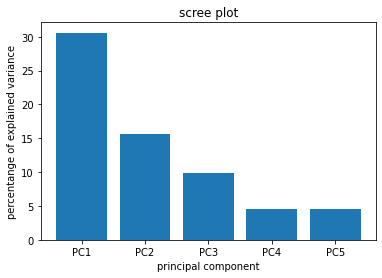

In [10]:
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('percentange of explained variance')
plt.xlabel('principal component')
plt.title('scree plot')
plt.show()

We then generate a scatterplot using the first two principle components.  The data does appear to have a few clusters. We'll analyze further below to see just how we'll be able to cluster the data.

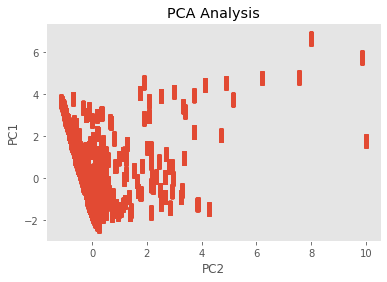

In [11]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

%matplotlib inline
X = df_PCA[['PC1','PC2']].values
plt.scatter(X[:,1], X[:,0]+np.random.random(X[:,1].shape)/2,
            s=20)

plt.xlabel('PC2'), plt.ylabel('PC1')
plt.grid()
plt.title('PCA Analysis')
plt.show()

### Cluster Analysis

We start by looping through various k values and fitting a KMeans cluster using euclidean to determine the optimal k value.  Here, it appears that k=6 is optimal given that's where the curve begins to flatten out in the below elbow graph.

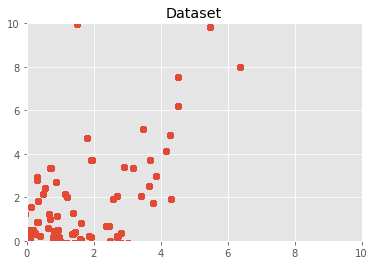

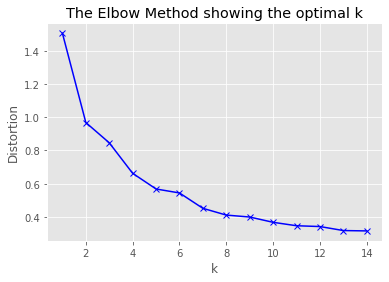

In [12]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

x1 = df_PCA[['PC1']].to_numpy()
x2 = df_PCA[['PC2']].to_numpy()

plt.plot()
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.title('Dataset')
plt.scatter(x1, x2)
plt.show()
# create new plot and data
plt.plot()
X = np.array(list(zip(x1, x2))).reshape(len(x1), 2)
colors = ['b', 'g', 'r']
markers = ['o','v','s']

# k means determine k
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [12]:
#get the first two principle components

X = df_PCA[['PC1','PC2']].values

Let's evaluate the optimal number of clusters for our data using the silhouette vs cluster size graph below.  It again appears that 6 clusters appears to be the optimal number of clusters as we can see the optimal Silhouette score using euclidean is highest at 6 clusters.

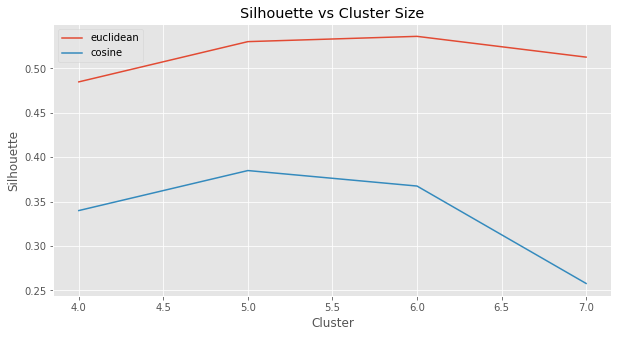

In [17]:
from sklearn.cluster import KMeans

seuclid = []
scosine = []
k = range(4,8)
for i in k:
    kmeans_model = KMeans(n_clusters=i, init="k-means++").fit(X)
    labels = kmeans_model.labels_
    seuclid.append(metrics.silhouette_score(X, labels, metric='euclidean'))
    scosine.append(metrics.silhouette_score(X, labels, metric='cosine'))
    
plt.figure(figsize=(10,5))
plt.plot(k,seuclid,label='euclidean')
plt.plot(k,scosine,label='cosine')
plt.ylabel("Silhouette")
plt.xlabel("Cluster")
plt.title("Silhouette vs Cluster Size")
plt.legend()
plt.show()

We then fit a k-means++ with n_clusters=6 based on our analysis above and plot the data again to see how the clusters are assigned.  It does appear that we are able to cluster and for the most part, the clusters do appear separable.

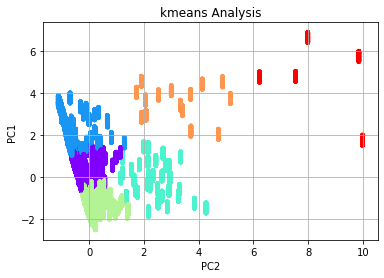

In [13]:
from sklearn.cluster import KMeans


cls = KMeans(n_clusters=6,init='k-means++',random_state=123)
cls.fit(X)

cluster_label = cls.labels_ #the labels from kmeans clustering

%matplotlib inline
plt.scatter(X[:,1], X[:,0]+np.random.random(X[:,1].shape)/2,
            c=cluster_label, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('PC2'), plt.ylabel('PC1')
plt.grid()
plt.title('kmeans Analysis')
plt.show()

## Measuring Effectiveness

Below, we calculate the silhouette score of our clusters.  The value closer to 1 between -1 and +1 indicates better clustering as measured by denseness and separability.

In [14]:
from sklearn.metrics import silhouette_score
silhouette_score(X, cluster_label)

0.5359916545678038

###  Describing the Results

Now, we'll take our cluster labels and add them back to the original dataset so that we can begin to analyze the patterns that make up the different clusters.  This will allow us to describe what is different about the clusters.

In [15]:
#here we are going to get the cluster labels and then add them back to the original data to identify patterns in the clusters for explain-ability
#get cluster labels
df_cluster_labels = pd.DataFrame(cluster_label, columns=['cluster_id'])
#load original csv
file_path = "C:\\Users\\BGaither\\OneDrive - McAfee\\Other\\school\\SMU\\Courses\\Fall 2020\\Machine Learning I\\Lab1\\Data_NYPD\\Modified_Data_Sets\\NYPD_Rollup_All_Crimes_Joined_All.csv"
#load Data into Pandas
df = pd.read_csv(file_path)
#add cluster labels back to original data
df_withLabs = pd.concat([df,df_cluster_labels],axis=1)

In [16]:
df_withLabs = df_withLabs[['Daytime','Day_Name','Month','Season','is_Holiday','is_Event','PRCP','SNOW','TMIN','TMAX','cluster_id']]
df_withLabs.head(5)

,Daytime,Day_Name,Month,Season,is_Holiday,is_Event,PRCP,SNOW,TMIN,TMAX,cluster_id
0,Day,Wednesday,January,Winter,1,1,0.0,0.0,24,33,1
1,Day,Wednesday,January,Winter,1,1,0.0,0.0,24,33,1
2,Day,Wednesday,January,Winter,1,1,0.0,0.0,24,33,1
3,Day,Wednesday,January,Winter,1,1,0.0,0.0,24,33,1
4,Day,Wednesday,January,Winter,1,1,0.0,0.0,24,33,1


In [17]:
df_mode = df_withLabs.groupby(['cluster_id']).apply(pd.DataFrame.mode).reset_index(drop=True).drop(df_withLabs[['PRCP','SNOW','TMIN','TMAX']], axis=1)
df_mode

,Daytime,Day_Name,Month,Season,is_Holiday,is_Event,cluster_id
0,Evening,Sunday,April,Spring,0,0,0
1,Evening,Wednesday,January,Winter,0,0,1
2,Evening,Wednesday,October,Fall,0,0,2
3,Night,Monday,August,Summer,0,0,3
4,Evening,Tuesday,January,Winter,0,0,4
5,Night,Thursday,February,Winter,0,0,5


In [18]:
df_avg = df_withLabs.groupby(['cluster_id']).agg(
            avg_PRCP=('PRCP','mean'),
            avg_Snow=('SNOW','mean'),
            avg_TMIN=('TMIN','mean'),
            avg_TMAX=('TMAX','mean')).reset_index(drop=True)
df_avg

,avg_PRCP,avg_Snow,avg_TMIN,avg_TMAX
0,0.057233,0.000000,47.344741,62.343401
1,0.035243,0.075731,24.867275,37.657917
2,1.231788,0.005680,56.112797,69.879448
3,0.046998,0.000000,66.958027,82.919093
4,0.793813,3.275501,23.134038,33.983037
5,1.828299,7.168891,24.398666,40.456214


Below, we have shown the average temp, precipitation, and snow along with the most frequent time related values to get an idea of the differences between the clusters and how to describe them.

In [19]:
df_explain = pd.concat([df_avg,df_mode],axis=1)
df_explain

,avg_PRCP,avg_Snow,avg_TMIN,avg_TMAX,Daytime,Day_Name,Month,Season,is_Holiday,is_Event,cluster_id
0,0.057233,0.000000,47.344741,62.343401,Evening,Sunday,April,Spring,0,0,0
1,0.035243,0.075731,24.867275,37.657917,Evening,Wednesday,January,Winter,0,0,1
2,1.231788,0.005680,56.112797,69.879448,Evening,Wednesday,October,Fall,0,0,2
3,0.046998,0.000000,66.958027,82.919093,Night,Monday,August,Summer,0,0,3
4,0.793813,3.275501,23.134038,33.983037,Evening,Tuesday,January,Winter,0,0,4
5,1.828299,7.168891,24.398666,40.456214,Night,Thursday,February,Winter,0,0,5


In [29]:
#label encode the categorical features
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

columns_to_encode = ['Daytime','Day_Name','Month','Season']
columns_no_change = ['is_Holiday','is_Event','PRCP','SNOW','TMIN','TMAX','cluster_id']

df_existing = df_withLabs[columns_no_change]
df_encoded = df_withLabs[columns_to_encode]
df_enc = df_withLabs

le = LabelEncoder()

df_enc[columns_to_encode] = df_withLabs[columns_to_encode].apply(le.fit_transform)
df_enc = df_enc[columns_to_encode+columns_no_change]

Pair plots with cluster color codes allow us to get a sense of how the clusters show separation.  We can se that there does appear to be a clear difference between clusters 1 and 0 in terms of temperature (TMIN and TMAX) as well as Months.  

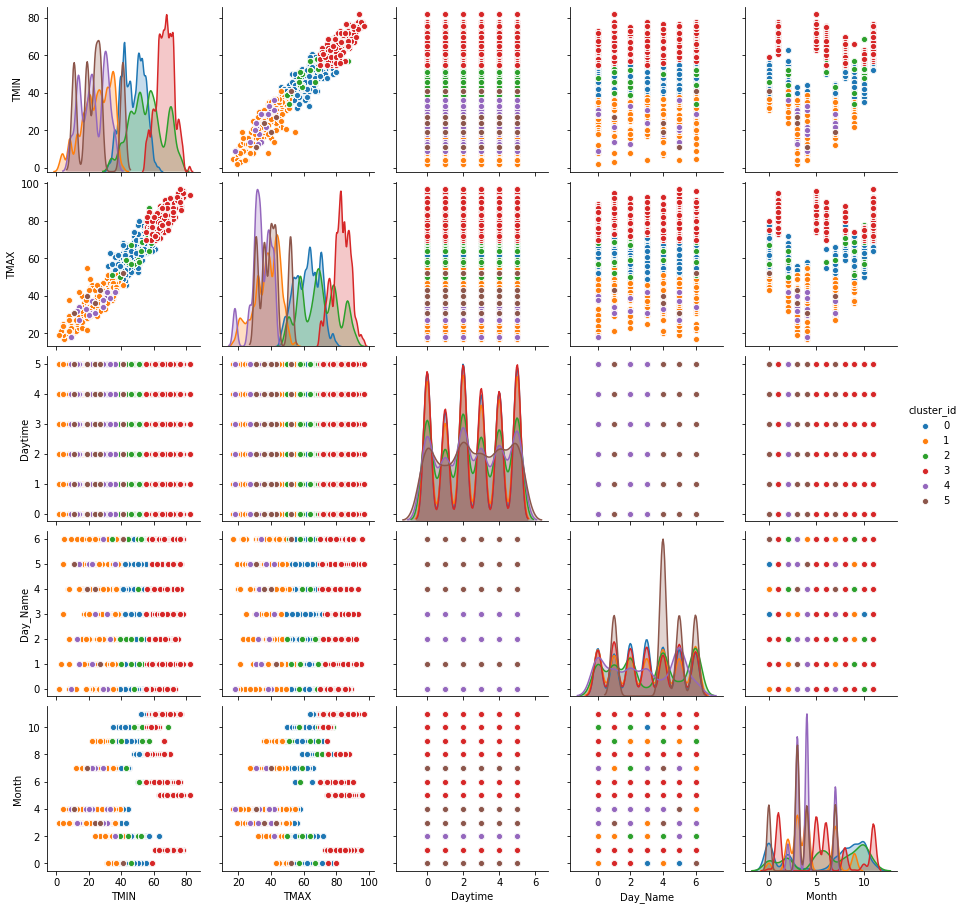

In [39]:
sns.pairplot(df_enc[['TMIN','TMAX','Daytime','Day_Name','Month','cluster_id']],hue='cluster_id')

## Summary

Below, we have used the data analyzed above to give meaning to the clusters identified.  This was done by looking at the mode of categorical data and the average of our continuous data by cluster along with visual representations from the pair plots above.

All clusters appear to primarily occur in the evening/night.

|Cluster id |Cluster Name | Description|
|:--------|:--------|:------------|
|Cluster 0| Fair Weather Fall Crimes | Occurs in Fall during the middle of the week in mild temperatures with little to no precipitation |
|Cluster 1 |Cold and Calm Crimes | Occurs in Fall during the middle of the week in mild temperatures with little to no precipitation |
|Cluster 2 |Fair Weather Sprint Crimes | Occurs in Spring on the weekend in mild temperatures with little to no precipitation |
|Cluster 3 |Cold and Inclimate Weather Crimes | Occurs in Winter during the week in cooler temperatures with heavy precipitation |
|Cluster 4 |Hot and Dry Crimes | Occurs in the Summer during the week in warmer weather with little to no precipitation |
|Cluster 5 |Cold and Moderate Crimes | Occurs in Winter during the week in cooler weather with moderate precipitation |

